In [280]:
import random
import numpy as np
import numpy.typing

import numba 


# TODO min pyver 3.8

import enum
import typing
import abc



class Coordinate(typing.NamedTuple):
    x: int
    y: int

    @classmethod
    def make(cls, x, y):
        return cls(x=int(x), y=int(y))

class Dimension(typing.NamedTuple):
    width: int
    height: int

    @classmethod
    def make(cls, width, height):
        return cls(width=int(width), height=int(height))




class Callback(dict):
    def register(
        self, 
        *callables: typing.Callable, 
        **keyed_callables: typing.Callable
    ):
        self.update(
            map(lambda f: (f, f), callables),
            **keyed_callables
        )
        return self

    # dispatch registered callbacks one by one
    def dispatch(self, *args, **kwargs):
        for f in self.values():
            yield f.__call__(*args, **kwargs)

    # dispatch all of the registered callbacks
    def __call__(self, *args, **kwargs):
        return list(self.dispatch(*args, **kwargs))


    

class TextSpec(typing.NamedTuple):
    content: str
    size: int
    rotation: float
    position: Coordinate = None

BilevelData = np.typing.NDArray[np.bool_]

import types

# NOTE coord system: origin upper left 
class CanvasBase(abc.ABC):
    def __init__(self):
        self.callbacks = types.SimpleNamespace(
            region_update=Callback[
                typing.Callable[
                    [CanvasBase, Coordinate, BilevelData], 
                    typing.Any
                ]
            ]()
        )

    @property
    @abc.abstractmethod
    def dimension(self) -> Dimension:
        raise NotImplementedError()

    @property
    @abc.abstractmethod
    def data_bilevel(self) -> BilevelData:
        raise NotImplementedError()

    @abc.abstractmethod
    def text(self, text_spec: TextSpec) -> Dimension:
        raise NotImplementedError()




# see https://stackoverflow.com/a/27087513/11934495
def shift(a, offsets, fill_value=np.nan):
    _mom = lambda s: s if s > 0 else 0
    _non = lambda s: s if s < 0 else None

    res = np.full_like(a, fill_value=fill_value)
    res[tuple(np.s_[_mom(o):_non(o)] for o in offsets)] \
        = a[tuple(np.s_[_mom(-o):_non(-o)] for o in offsets)]

    return res


@numba.jit
def rgba_frac_to_rgba(rgba: np.typing.NDArray):
    return np.multiply(rgba, 255).astype(np.uint8)

@numba.jit
def rgb_apply_a(
    rgb: np.typing.NDArray,
    a: np.typing.NDArray
):
    return (a / 255. * rgb).astype(np.uint8)

class RGBAChannel(enum.IntEnum):
    R = 0
    G = 1
    B = 2
    A = 3


#@numba.jit
def rgba_to_rgb(
    rgba: np.typing.NDArray, 
    rgb_background: np.typing.NDArray
) -> np.typing.NDArray:
    chan = RGBAChannel

    return (
        rgb_apply_a(
            rgb=rgba[..., np.array([chan.R, chan.G, chan.B])], 
            a=rgba[..., np.array([chan.A])]
        ) + rgb_apply_a(
            rgb=rgb_background, 
            a=255 - rgba[..., np.array([chan.A])]
        )             
    )

#@numba.jit
def rgb_to_bilevel(
    rgb: np.typing.NDArray, 
    rgb_background: np.typing.NDArray
) -> np.typing.NDArray:
    rgb = rgb.astype(np.uint8)
    rgb_background = rgb_background.astype(np.uint8)
    
    return (rgb != rgb_background).all(axis=-1)





import matplotlib as mpl
import matplotlib.backends.backend_agg


class CanvasMPL(CanvasBase):
    def __init__(
        self, 
        backend: typing.Type[mpl.figure.FigureCanvasBase]
            =mpl.backends.backend_agg.FigureCanvas,
        figure: mpl.figure.FigureBase=None
    ):
        super().__init__()
        self._base = backend(figure=figure)

    @property
    def _figure(self):
        return self._base.figure

    @property
    def _background_rgb(self) -> np.typing.NDArray:
        r, g, b, _ = rgba_frac_to_rgba(
            np.asarray(self._figure.get_facecolor()), 
        )
        return np.asarray((r, g, b))

    # NOTE dimension follows the ones in `data_bilevel`
    @property
    def dimension(self) -> Dimension:
        _, _, width, height = self._figure.get_window_extent(
            renderer=self._base.get_renderer()
        ).bounds
        return Dimension.make(width=height, height=width)

    @property
    def data_rgba(self) -> np.typing.NDArray:
        return np.asarray(
            self._base.copy_from_bbox(self._figure.bbox),
            dtype=np.uint8
        )

    @property
    def data_rgb(self) -> np.typing.NDArray:
        return rgba_to_rgb(
            self.data_rgba, 
            rgb_background=self._background_rgb
        )

    @property
    def data_bilevel(self) -> np.typing.NDArray:
        return rgb_to_bilevel(
            self.data_rgb, 
            rgb_background=self._background_rgb
        )

    # position: coordinate in `data_bilevel`
    # dimension: follows coordinate convention in `data_bilevel`

    # NOTE coordinate convention: xy reversed!
    def text(self, text_spec: TextSpec) -> Dimension:
        def _draw(f: mpl.figure.Figure, render: bool):
            if not render:
                return f.draw_without_rendering()
            return f.draw(renderer=f.canvas.get_renderer())

        def _get_extent(t: mpl.text.Text):
            b = t.get_bbox_patch()
            if b is not None:
                return b.get_window_extent()
            return t.get_window_extent(
                renderer=t.get_figure().canvas.get_renderer()
            )

        pos = text_spec.position
        t = self._figure.add_artist(
            mpl.text.Text(
                text=text_spec.content,
                size=text_spec.size,
                rotation=text_spec.rotation,
                transform=None  # do not translate xy coords
            )
        )

        # TODO offset
        _, _, width_f, height_f = self._figure.bbox.bounds        
        _, _, width, height = _get_extent(t).bounds

        if text_spec.position is not None:
            t.set(
                # TODO NOTE invert y axis!!!!
                x=pos.y, y=height_f - height - pos.x,
                #x=pos.y, y=pos.x
            )
            
            _draw(self._figure, render=True)

            # TODO rm
            print('text', pos.y, height_f - height - pos.x)
            print('text', text_spec, _get_extent(t).bounds)   

            # TODO updated region
            self.callbacks.region_update.__call__(self, text_spec.position, None)
        else:
            # hidden
            t.remove()

        return Dimension.make(width=height, height=width)






import contextlib


def setattrs(o, **attrs):
    for k, v in attrs.items():
        setattr(o, k, v)

def delattrs(o, *attrs):
    for k in attrs:
        delattr(o, k)

def getattrs(o, *attrs):
    return {k: getattr(o, k) for k in attrs}
        

# see https://stackoverflow.com/a/38532086/11934495
@contextlib.contextmanager
def context_setattrs(o, **attrs):
    noattrs_orig = set(filter(
        lambda k: not hasattr(o, k), 
        attrs.keys()
    ))
    attrs_orig = getattrs(
        o, *(set(attrs.keys()) - noattrs_orig)
    )

    setattrs(o, **attrs)
    yield

    setattrs(o, **attrs_orig)
    delattrs(o, *noattrs_orig)


import PIL
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont

class CanvasPIL(CanvasBase):
    def __init__(self):



        pass

    @property
    def dimension(self) -> Dimension:
        raise NotImplementedError()

    @property
    def data_bilevel(self) -> BilevelData:
        raise NotImplementedError()

    def text(self, text_spec: TextSpec) -> Dimension:
        # calculate size after rotation without rendering
        def rotate_size(image: PIL.Image, *args, **kwargs):
            with context_setattrs(
                image, 
                transform=lambda size, *args, **kwargs: size
            ):
                return image.rotate(*args, **kwargs)


        raise NotImplementedError()



# see https://en.wikipedia.org/wiki/Summed-area_table
class SummedAreaTable:
    @staticmethod
    #@numba.jit
    def _make(a: np.typing.NDArray):
        return np.apply_over_axes(
            np.cumsum, 
            a, 
            axes=np.arange(2)
        )

    def __init__(self, a: np.typing.NDArray):
        self.base = self._make(a)

    @staticmethod
    @numba.jit
    def _area(
        a: np.typing.NDArray, 
        offset: Coordinate, 
        block_size: Dimension
    ):
        x, y = offset
        x_block, y_block = block_size

        return (
            (a[x + x_block, y + y_block] - a[x + x_block, y])
                - (a[x, y + y_block] - a[x, y])
        )

    def area(
        self,
        offset: Coordinate,
        block_size: Dimension
    ):
        return self._area(self.base, offset, block_size)

    def walk(
        self,
        block_size: Dimension
    ):
        x_max, y_max = self.base.shape
        x_block, y_block = block_size

        for x in range(x_max - x_block):
            for y in range(y_max - y_block):
                offset = Coordinate(x, y)
                yield offset, self.area(
                    offset=offset, 
                    block_size=block_size
                )

    @staticmethod
    @numba.jit
    def _area_matrix(
        a: np.typing.NDArray, 
        block_size: Dimension
    ):
        x_block, y_block = block_size
        return (
            (a[x_block:, y_block:] - a[x_block:, :-y_block])
                - (a[:-x_block, y_block:] - a[:-x_block, :-y_block])
        )    

    def area_matrix(
        self,
        block_size: Dimension
    ):
        return self._area_matrix(self.base, block_size)

    # TODO test
    def _rm_area_matrix_comp(self,
        block_size: Dimension):

        x_max, y_max = self.base.shape
        x_block, y_block = block_size

        res = np.full(((x_max - x_block), (y_max - y_block)), fill_value=np.nan)
        for x in range(x_max - x_block):
            for y in range(y_max - y_block):
                offset = Coordinate(x, y)
                res[x, y] = self.area(
                    offset=offset, 
                    block_size=block_size
                )

        return res







class OccupancyMap:
    def __init__(
        self, 
        canvas: CanvasBase, 
        mask: typing.Union[np.typing.ArrayLike, None]=None
    ):
        self._canvas = canvas
        self._mask = mask

        self._data = None
        def _f_update(*args, **kwargs):
            d = self._canvas.data_bilevel
            if self._mask is not None:
                d += self._mask
            self._data = SummedAreaTable(d.astype(np.uint))
        _f_update()
        self._canvas.callbacks.region_update[self] = _f_update

    def __del__(self):
        self._canvas.callbacks.region_update.pop(self)

    @property
    def canvas(self) -> CanvasBase:
        return self._canvas

    @property
    def data(self) -> SummedAreaTable:
        return self._data

    def query_position(
        self, 
        block_size: Dimension
    ) -> typing.Iterator[Coordinate]:
        for pos, area in self.data.walk(block_size):
            # unoccupied area
            if not area:
                yield pos
    
    def positions(
        self,
        block_size: Dimension
    ):
        a = self.data.area_matrix(block_size)
        # unoccupied area == 0
        return np.argwhere(a == 0)

    def sample_position(
        self, 
        block_size: Dimension, 
        random_state: random.Random
    ) -> Coordinate:
        r = self.positions(block_size)
        if r.size == 0:
            return None
        return Coordinate(*random_state.choice(r))



class Range:
    def __init__(
        self, 
        start: typing.Any, stop: typing.Any, 
        step: typing.Any=None,
        include: typing.List[typing.Literal['start', 'stop']]=['start']
    ):
        self.start = start
        self.stop = stop
        self.step = step
        self.include = include

    @staticmethod
    def _lteq(a, b, eq) -> bool: 
        return (a <= b) if eq else (a < b)

    def _is_after_start(self, n) -> bool:
        return self._lteq(self.start, n, 'start' in self.include)

    def _is_before_stop(self, n) -> bool:
        return self._lteq(n, self.stop, 'stop' in self.include)

    def __contains__(self, n) -> bool:
        return (
            (
                self._is_after_start(n)
                    and self._is_before_stop(n)
            ) and (
                n % self.step == 0 
                    if self.step is not None else 
                True
            )
        )

    def __iter__(self):
        if self.step is None:
            raise TypeError('''Range without 'step' is not iterable''')

        # TODO
        '''
        value = self.start
        if self.step > 0:
            while value < self.stop:
                yield value
                value += self.step
        else:
            while value > self.stop:
                yield value
                value += self.step
        '''





class TextPlacement:
    def __init__(self, 
        canvas: CanvasBase, 
        occupancy: OccupancyMap, 
        random_state: random.Random
    ):
        self.canvas = canvas
        self.occupancy = occupancy
        self.random_state = random_state

    def add(
        self, 
        text: str, 
        size_range: typing.Tuple[float, float], 
        size_step: float, 

        # TODO use range object
        #rotation_range: range
        rotation_range: typing.Tuple[float, float], 
        rotation_step: float, 

        rotation_prob: float,
    ) -> TextSpec:
        random_state = self.random_state
        canvas = self.canvas
        occupancy = self.occupancy
        size_min, size_max = size_range
        rotation_min, rotation_max = rotation_range

        def _impl(size: float, rotation: float):
            if size is None:
                return None

            if not (size_min <= size and size <= size_max):
                return None

            if not (rotation_min <= rotation and rotation <= rotation_max):
                return None
            
            dim = canvas.text(TextSpec(
                content=text, 
                size=size, 
                position=None, 
                rotation=rotation
            ))

            # try to find a position
            pos = occupancy.sample_position(dim, random_state=random_state)
            if pos is not None:
                return TextSpec(
                    content=text,
                    size=size, 
                    position=pos, 
                    rotation=rotation
                )

            # if we didn't find a place...
            # first try to rotate!
            res = _impl(
                size=size, 
                rotation=rotation + rotation_step
            )
            if res is not None:
                return res

            # make font smaller
            res = _impl(
                size=size - size_step, 
                rotation=rotation
            )
            if res is not None:
                return res

            return None

        rotation = rotation_min
        if random_state.random() < rotation_prob:
            rotation = random_state.choice(
                range(
                    rotation_min, 
                    rotation_max + rotation_step, 
                    rotation_step
                )
            )
        
        return _impl(size=size_max, rotation=rotation)






import collections.abc

class FrequencyData(typing.NamedTuple):
    token: typing.Any
    frequency: float

class DescendingFrequencyTable:
    @staticmethod
    def _sorted(a: typing.Iterable[FrequencyData]):
        return sorted(
            a, 
            key=lambda x: x.frequency, 
            reverse=True
        )

    @classmethod
    def from_iter(cls, a: typing.Iterable):
        return cls(map(lambda x: FrequencyData(**x), a))

    try:
        import pandas as pd

        @classmethod
        def from_dataframe(cls, df: pd.DataFrame):
            return cls.from_iter(df.to_dict('records'))

        @classmethod
        def from_data(cls, a: typing.Iterable):
            df_token_freqs = cls.pd.Series(a).value_counts()

            return cls.from_dataframe(
                cls.pd.DataFrame({
                    'token': df_token_freqs.index,
                    'frequency': df_token_freqs.values
                })
            )
    except ModuleNotFoundError:
        pass 

    def __init__(self, a: typing.Iterable[FrequencyData]):
        self.base = self._sorted(a)

    def head(self, n):
        inst = self.__new__(self.__class__)
        inst.base = self.base[:n]
        return inst

    @property
    def items(self):
        return self.base

        




class TagCloud:
    class TextParams(typing.TypedDict):
        size_min: int
        size_max: typing.Union[int, None]
        size_step: int
        size_rescaling: float
        rotation_range: typing.Tuple[float, float]
        rotation_step: float
        rotation_prob: float

    def __init__(
        self, 
        canvas_backend: typing.Type[CanvasBase],
        random_state: random.Random=random.Random()
    ):
        self.canvas_backend = canvas_backend
        self.random_state = random_state

    # mask: boolean mask
    def _generate_layout(
        self,
        frequency_table: DescendingFrequencyTable, 
        canvas: CanvasBase,
        bool_mask: typing.Union[np.typing.ArrayLike, None],
        text_props: TextParams
    ) -> typing.Iterator[TextSpec]:
        random_state = self.random_state

        occupancy = OccupancyMap(canvas, mask=bool_mask)
        text_placement = TextPlacement(
            canvas=canvas, 
            occupancy=occupancy, 
            random_state=random_state
        )

        last_freq = None

        for token, freq in frequency_table.items:
            if freq == 0:
                continue

            # select the text size
            text_size_min, text_size_max = text_props['size_min'], text_props['size_max']
            text_size_scaling = text_props['size_rescaling']
            if last_freq is not None and text_size_scaling != 0:
                text_size_max *= (
                    text_size_scaling * (freq / float(last_freq))
                        + (1 - text_size_scaling)
                )

            text_spec = text_placement.add(
                text=token, 
                size_range=(text_size_min, text_size_max), 
                size_step=text_props['size_step'], 
                rotation_range=text_props['rotation_range'],
                rotation_step=text_props['rotation_step'],
                rotation_prob=text_props['rotation_prob']
            )
            # we were unable to draw any more
            if text_spec is None:
                break

            # draw the text
            canvas.text(text_spec)
            yield text_spec

            last_freq = freq

            # TODO rm debug
            continue
            fig, ax = plt.subplots(2)
            ax[0].imshow(text_placement.occupancy.data.base.astype(np.bool_))
            ax[1].imshow(canvas.data_bilevel)
            plt.suptitle(token)
            plt.show()

    def draw(
        self,
        frequency_table: DescendingFrequencyTable, 
        canvas_props=dict(),
        bool_mask=None,
        text_props=dict()
    ) -> CanvasBase:
        text_props = {
            **dict(
                size_min=5., size_max=None,
                size_step=1.,
                size_rescaling=.5,
                rotation_range=(0, 90),
                rotation_step=90,
                rotation_prob=.5
            ),
            **text_props
        }

        def _make_canvas():
            return self.canvas_backend(**canvas_props)

        def _find_text_size_max(n_samples):
            nonlocal self, frequency_table, canvas_props

            canvas = _make_canvas()

            # maximum text size when horizontal
            size_max = canvas.dimension.height

            # we only have one token. We make it big!
            if len(frequency_table.items) == 1:
                return size_max

            sizes = np.fromiter(map(
                lambda x: x.size, 
                self._generate_layout(
                    frequency_table=frequency_table.head(n=n_samples),
                    canvas=canvas,
                    bool_mask=bool_mask,
                    text_props={
                        **text_props,
                        'size_max': size_max
                    }
                )
            ), float)
            
            if len(sizes) < 1:
                raise Exception('canvas out of space')

            if len(sizes) == 1:
                return sizes[0]

            return 2 * np.prod(sizes) / np.sum(sizes)

        if text_props.get('size_max', None) is None:
            text_props['size_max'] = _find_text_size_max(
                n_samples=2
            )

        canvas = _make_canvas()
        layout = list(self._generate_layout(
            frequency_table=frequency_table,
            canvas=canvas,
            bool_mask=bool_mask,
            text_props=text_props
        ))

        # TODO
        return canvas

In [281]:
import pandas as pd

import nltk
import string

tokens_blocked = (
    set(nltk.corpus.stopwords.words('english'))
        | set(string.punctuation)
)

tokens = nltk.corpus.genesis.words('english-kjv.txt')

df_tokens = pd.Series(filter(lambda x: x not in tokens_blocked, tokens))
df_token_freqs = df_tokens.value_counts()

df_token_freqs_ = pd.DataFrame({
    'token': df_token_freqs.index,
    'frequency': df_token_freqs.values
})
df_token_freqs_

,token,frequency
0,And,1250
1,unto,590
2,I,484
3,said,476
4,thou,272
...,...,...
2656,half,1
2657,golden,1
2658,wit,1
2659,wondering,1


In [277]:
# TODO rm
import matplotlib.pyplot as plt

In [278]:
wc = TagCloud(canvas_backend=CanvasMPL)

c = wc.draw(
    frequency_table=DescendingFrequencyTable.from_dataframe(df_token_freqs_).head(200),
    text_props=dict(
        size_max=200,
        rotation_range=(0, 0),
        rotation_step=90,
        rotation_prob=.5
    )
)
_ = plt.imshow(c.data_rgba)

text 36 73.0
text TextSpec(content='And', size=200, rotation=0, position=Coordinate(x=137, y=36)) (36.0, 15.0, 542.5, 270.0)
text 45 283.0
text TextSpec(content='unto', size=147.2, rotation=0, position=Coordinate(x=0, y=45)) (45.0, 241.0, 464.25, 197.0)
text 553 112.0
text TextSpec(content='I', size=182.03389830508473, rotation=0, position=Coordinate(x=122, y=553)) (553.0, 59.0, 74.75, 246.0)
text 43 396.0
text TextSpec(content='said', size=63.347107438016536, rotation=0, position=Coordinate(x=0, y=43)) (43.0, 378.0, 180.0, 84.0)
text 395 399.0
text TextSpec(content='thou', size=60.14285714285714, rotation=0, position=Coordinate(x=0, y=395)) (395.0, 382.0, 189.875, 81.0)
text 497 305.0
text TextSpec(content='thy', size=63.16176470588235, rotation=0, position=Coordinate(x=91, y=497)) (497.0, 287.0, 142.0, 84.0)
text 182 1.0
text TextSpec(content='thee', size=54.25468164794006, rotation=0, position=Coordinate(x=406, y=182)) (182.0, -15.0, 169.75, 73.0)
text 11 1.0
text TextSpec(content='

KeyboardInterrupt: 

text 48 22.0
text TextSpec(content='this', size=200, rotation=0, position=Coordinate(x=188, y=48)) (48.0, -36.0, 506.875, 270.0)
text 48 271.0
text TextSpec(content='more', size=150.0, rotation=0, position=Coordinate(x=7, y=48)) (48.0, 228.0, 539.75, 202.0)
text 307 389.0
text TextSpec(content='stuff', size=67.0, rotation=0, position=Coordinate(x=1, y=307)) (307.0, 370.0, 209.375, 90.0)
text 3 400.0
text TextSpec(content='yeehaw', size=57.0, rotation=0, position=Coordinate(x=4, y=3)) (3.0, 384.0, 307.625, 76.0)
text 439 179.0
text TextSpec(content='uwu', size=67.0, rotation=0, position=Coordinate(x=211, y=439)) (439.0, 160.0, 194.125, 90.0)
text 209 187.0
text TextSpec(content='test', size=56.0, rotation=0, position=Coordinate(x=217, y=209)) (209.0, 171.0, 149.125, 76.0)


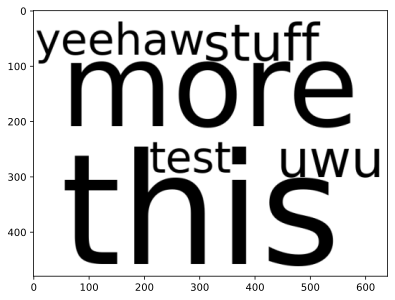

In [282]:
wc = TagCloud(canvas_backend=CanvasMPL)

c = wc.draw(
    frequency_table=DescendingFrequencyTable([
        FrequencyData('test', 1),
        FrequencyData('this', 10),
        FrequencyData('more', 5),
        FrequencyData('stuff', 5),
        FrequencyData('yeehaw', 5),
        FrequencyData('uwu', 5),
    ]),
    text_props=dict(
        size_max=200,
        rotation_range=(0, 0),
        rotation_step=90,
        rotation_prob=.5
    )
)
plt.imshow(c.data_rgba)

In [3]:
a = np.random.rand(640, 480)
d = Dimension(10, 5)

v = SummedAreaTable(a).area_matrix(d)
v_compr = SummedAreaTable(a)._rm_area_matrix_comp(d)

assert np.allclose(v, v_compr)

In [15]:
a = np.random.rand(50000, 5000)

In [9]:
%timeit np.argwhere(a == 0)

58.9 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
sa = SummedAreaTable(a)
%timeit _ = sa.area_matrix(d)

2.17 s ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) None
text 0 216.0
text TextSpec(content='tis a test', size=189, rotation=0, position=Coordinate(x=10, y=0)) (0.0, 161.0, 1144.75, 254.0)
text Dimension(width=254, height=1144)
text 259 -664.75
text TextSpec(content='tis a test', size=189, rotation=-90, position=Coordinate(x=0, y=259)) (259.0, -719.75, 254.00000000000023, 1144.75)
text Dimension(width=1144, height=254)
(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


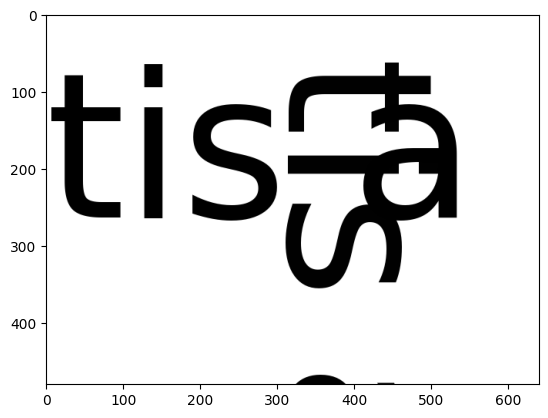

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


In [228]:

c = CanvasMPL(figure=mpl.backends.backend_agg.FigureCanvas(figure=mpl.figure.Figure()).figure)

#c._ax.axis('off')

c_stats = lambda: print(c._base.figure.bbox.bounds, c._base.figure.canvas.figure.bbox.bounds, c._base.figure.canvas._lastKey)


c_stats()
#c.text(TextSpec('tis a test', size=None, position=(0, 0), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(10, 10), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(100, 100), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(640 - 100, 480 - 100), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=480, position=Coordinate(200, 0), rotation=None))
#c_stats()
#plt.imshow(c.data_rgba)
#plt.show()

print(
'text',
#c.text(TextSpec('tis a test', size=189, position=Coordinate(0, 259), rotation=90))    
c.text(TextSpec('tis a test', size=189, position=Coordinate(10, 0), rotation=0))    
)

print(
'text',
#c.text(TextSpec('tis a test', size=189, position=Coordinate(0, 259), rotation=90))    
c.text(TextSpec('tis a test', size=189, position=Coordinate(0, 259), rotation=-90))    
)

c_stats()


plt.imshow(c.data_rgba)
plt.show()
c_stats()

In [223]:
c._figure.bbox.bounds

(0.0, 0.0, 640.0, 480.0)

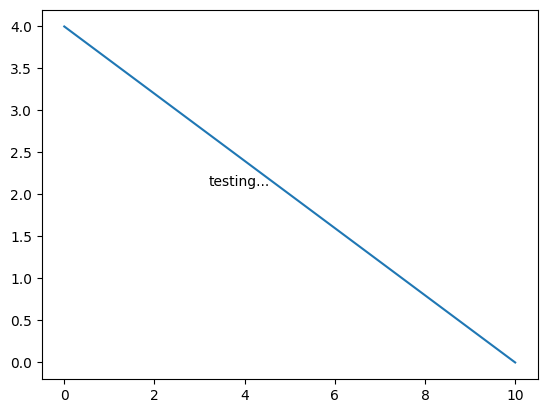

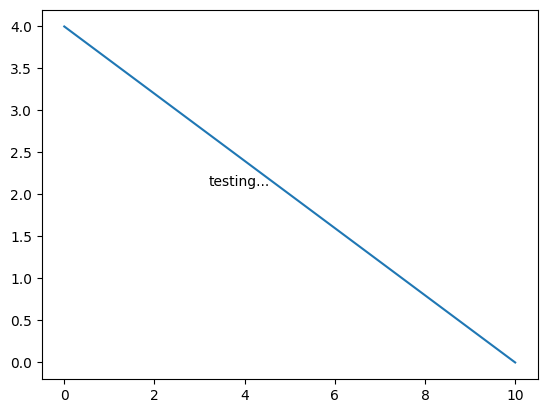

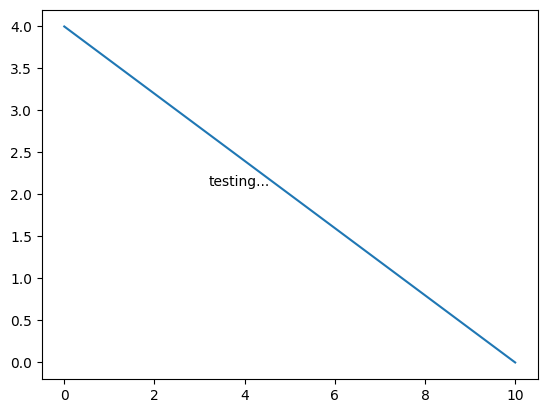

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
ax = f.add_subplot(111)
ax.plot([0,10], [4,0])

t = ax.text(3.2, 2.1, "testing...")
t.set_rotation('horizontal')

import copy

f_ = copy.deepcopy(t.figure)
t.figure

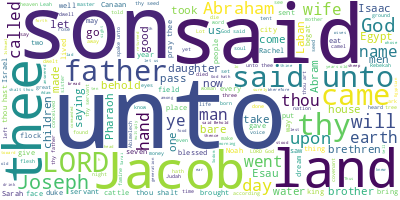

In [274]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

plt.style.use('default')

import tagcloud

#tagcloud.TagCloud().generate('this is a test token cloud and many more and funny')
#display(tagcloud.TagCloud().generate('this is a test token cloud and many more').to_image())

tagcloud.TagCloud(background_color=None, mode='RGBA').generate(nltk.corpus.genesis.open('english-kjv.txt').read()).to_image()


In [ ]:
dir(tagcloud)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'generate_from_frequencies']